In [1]:
import pandas as pd
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
basedir = './국토교통부_실거래가_공개시스템/땅값분석/'
yunrip_df = pd.read_csv(basedir + 'yunrip_30.csv')
commerce_df = pd.read_csv(basedir + 'commerce_30.csv')
land_df = pd.read_csv(basedir + 'land.csv')

In [3]:
common_cols = ['시군구', '번지', '용도지역', '도로조건', '계약날짜', '대지면적(㎡)', '거래금액(만원)', '단가(㎡)', '단가(평)', '거래유형', '건물연식']
common_df = pd.concat([yunrip_df[common_cols], commerce_df[common_cols], land_df[[col for col in land_df.columns if col not in ['지목', '지분구분', '해제사유발생일']]]])
common_df['계약날짜'] = pd.to_datetime(common_df['계약날짜'], format='%Y-%m-%d')
print(common_df.shape)
common_df.head()

(167792, 11)


,시군구,번지,용도지역,도로조건,계약날짜,대지면적(㎡),거래금액(만원),단가(㎡),단가(평),거래유형,건물연식
0,서울특별시 강남구 개포동,171-13,제2종일반주거지역,8m미만,2019-10-23,56.1,60000.0,1069.518717,3535.598930,연립/다세대,31.0
1,서울특별시 강남구 개포동,1239-7,제2종일반주거지역,8m미만,2018-06-14,45.0,52000.0,1155.555556,3820.018222,연립/다세대,30.0
2,서울특별시 강남구 개포동,1239-7,제2종일반주거지역,8m미만,2019-03-05,45.0,50000.0,1111.111111,3673.094444,연립/다세대,31.0
3,서울특별시 강남구 개포동,1239-7,제2종일반주거지역,8m미만,2020-06-01,45.0,58000.0,1288.888889,4260.789556,연립/다세대,32.0
4,서울특별시 강남구 개포동,1239-7,제2종일반주거지역,8m미만,2020-06-13,45.0,57000.0,1266.666667,4187.327667,연립/다세대,32.0


In [4]:
dandok_filenames = [f for f in os.listdir('./국토교통부_실거래가_공개시스템/단독다가구매매/') if (f.endswith('.csv'))&('(매매)' in f)]
dandok_filenames

['단독다가구(매매)_실거래가_20130101_20131231.csv',
 '단독다가구(매매)_실거래가_20140101_20141231.csv',
 '단독다가구(매매)_실거래가_20150101_20151231.csv',
 '단독다가구(매매)_실거래가_20160101_20161231.csv',
 '단독다가구(매매)_실거래가_20170101_20171231.csv',
 '단독다가구(매매)_실거래가_20180101_20181231.csv',
 '단독다가구(매매)_실거래가_20190101_20191231.csv',
 '단독다가구(매매)_실거래가_20200101_20201231.csv',
 '단독다가구(매매)_실거래가_20210101_20210406.csv']

In [5]:
dfs_list = []
for f in dandok_filenames:
    df = pd.read_csv('./국토교통부_실거래가_공개시스템/단독다가구매매/' + f, encoding='euc-kr', header=15)
    if '해제사유발생일' in df.columns:
        df = df[df['해제사유발생일'].isna()]
        df = df.drop(columns=['해제사유발생일'])
    dfs_list.append(df)

In [6]:
dandok_df = pd.concat(dfs_list).reset_index(drop=True)
print(dandok_df.shape)
dandok_df.head()

(108219, 11)


,시군구,번지,주택유형,도로조건,연면적(㎡),대지면적(㎡),계약년월,계약일,거래금액(만원),건축년도,도로명
0,서울특별시 강남구 논현동,8*,다가구,8m미만,329.78,165.4,201305,24,"177,500",1993.0,논현로138길
1,서울특별시 강남구 논현동,1**,다가구,8m미만,335.90,171.4,201312,18,"173,500",1990.0,학동로12길
2,서울특별시 강남구 논현동,7*,다가구,8m미만,435.32,177.2,201304,23,"138,000",1992.0,논현로146길
3,서울특별시 강남구 논현동,1**,다가구,8m미만,347.10,181.9,201308,28,"169,000",1991.0,선릉로135길
4,서울특별시 강남구 논현동,2**,다가구,8m미만,401.33,193.8,201305,21,"179,000",1997.0,논현로124길


In [7]:
dandok_df['구'] = dandok_df['시군구'].apply(lambda x: x.split(' ')[1])
dandok_df['동'] = dandok_df['시군구'].apply(lambda x: x.split(' ')[2])
dandok_df['거래금액(만원)'] = dandok_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
dandok_df['대지면적(㎡)'] = dandok_df['대지면적(㎡)'].apply(float)
dandok_df['단가(평)'] = dandok_df['거래금액(만원)'] / dandok_df['대지면적(㎡)'] * 3.305785

In [8]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [9]:
dandok_df['계약날짜'] = dandok_df['계약년월'].apply(lambda x: str(x)[:4]) + '-' +\
dandok_df['계약년월'].apply(lambda x: str(x)[-2:]) + '-' + dandok_df['계약일'].apply(day_modifier)

In [10]:
dandok_df['계약날짜'] = pd.to_datetime(dandok_df['계약날짜'])

In [11]:
dandok_df.drop(columns=['계약년월', '계약일'], inplace=True)

In [12]:
target = '개봉동'
target_purpose = '3종일반'
date_today = pd.to_datetime(datetime.datetime.now())

In [13]:
target_df = common_df[
    (common_df['시군구'].str.contains(target))
    &(common_df['용도지역'].str.contains(target_purpose))
    &(common_df['계약날짜'] <= date_today)
    &(common_df['계약날짜'] >= (date_today - pd.DateOffset(years=3)))
].sort_values(['단가(평)'], ascending=False)
print(target_df.shape)
target_df.head()

(58, 11)


,시군구,번지,용도지역,도로조건,계약날짜,대지면적(㎡),거래금액(만원),단가(㎡),단가(평),거래유형,건물연식
9520,서울특별시 구로구 개봉동,4**,제3종일반주거,25m이상,2020-05-25,744.80,950000.0,1275.510204,4216.562500,상업/업무,37.0
9519,서울특별시 구로구 개봉동,9*,제3종일반주거,25m미만,2020-04-15,160.00,195000.0,1218.750000,4028.925469,상업/업무,36.0
9521,서울특별시 구로구 개봉동,1**,제3종일반주거,25m미만,2020-05-27,79.43,90000.0,1133.073146,3745.696210,상업/업무,32.0
9526,서울특별시 구로구 개봉동,4**,제3종일반주거,25m이상,2020-11-06,33.36,36000.0,1079.136691,3567.393885,상업/업무,44.0
6874,서울특별시 구로구 개봉동,170-37,제3종일반주거지역,8m미만,2020-08-25,32.80,34500.0,1051.829268,3477.121418,연립/다세대,42.0


In [14]:
dandok_target_df = dandok_df[
    (dandok_df['시군구'].str.contains(target))
    &(dandok_df['계약날짜'] <= date_today)
    &(dandok_df['계약날짜'] >= (date_today - pd.DateOffset(years=3)))
].sort_values(['단가(평)'], ascending=False)
print(dandok_target_df.shape)
dandok_target_df.head()

(304, 13)


,시군구,번지,주택유형,도로조건,연면적(㎡),대지면적(㎡),거래금액(만원),건축년도,도로명,구,동,단가(평),계약날짜
97674,서울특별시 구로구 개봉동,3**,다가구,8m미만,323.07,162.3,200000,2010.0,개봉로19길,구로구,개봉동,4073.672212,2020-05-12
106701,서울특별시 구로구 개봉동,3**,다가구,8m미만,323.07,162.3,200000,2010.0,개봉로19길,구로구,개봉동,4073.672212,2021-02-22
87113,서울특별시 구로구 개봉동,2**,단독,12m미만,299.64,131.6,128500,1994.0,개봉로12길,구로구,개봉동,3227.913165,2019-10-01
87134,서울특별시 구로구 개봉동,7*,단독,8m미만,90.75,152.0,120000,2000.0,고척로18길,구로구,개봉동,2609.830263,2019-10-07
97706,서울특별시 구로구 개봉동,2**,단독,8m미만,199.52,126.6,99000,1984.0,개봉로10길,구로구,개봉동,2585.092536,2020-06-16


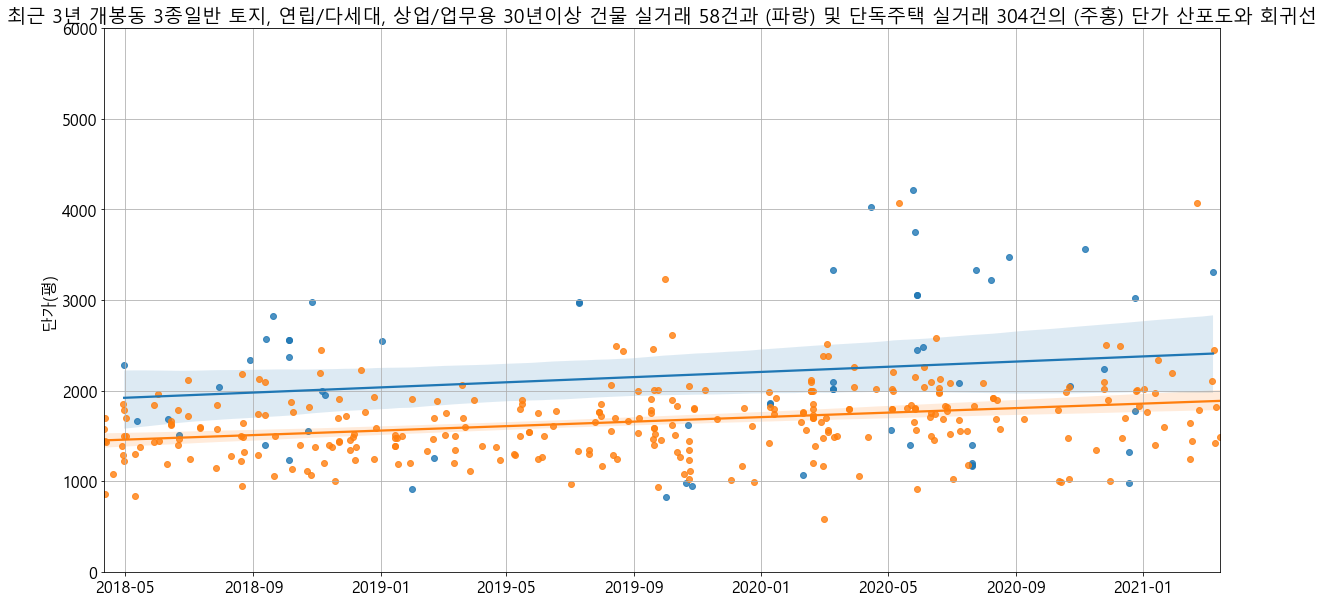

In [16]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 3년 {} {} 토지, 연립/다세대, 상업/업무용 30년이상 건물 실거래 {}건과 (파랑) 및 단독주택 실거래 {}건의 (주홍) 단가 산포도와 회귀선'.format(target, target_purpose, target_df.shape[0], dandok_target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(평)'])
ax.xaxis.update_units(dandok_target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(dandok_target_df['계약날짜']), y=dandok_target_df['단가(평)'])
plt.ylim([0, 6000])
plt.savefig(basedir + '{}_{}/산포도.png'.format(target, target_purpose))